# 🔬 Predicting Diabetes & Diabetic Eye Risk (PIMA Extended + Retina)

Ce notebook présente une étude complète sur la prédiction du **diabète** et
de certains facteurs associés (tension, maladies cardiaques, tabagisme, etc.)
à partir d’un dataset de type PIMA **étendu** avec des informations
complémentaires :

- variables cliniques (glycémie, tension artérielle, IMC, etc.)
- antécédents (grossesses, héritabilité diabétique, hypertension, maladie cardiaque…)
- variables de style de vie (tabagisme)
- métadonnées rétiniennes (images gauche / droite, stades DR) que l’on retirera
  pour le premier modèle.

Objectifs du notebook :

1. Nettoyer et préparer les données pour l’analyse.
2. Construire plusieurs modèles de classification :
   - Régression logistique (baseline linéaire)
   - Random Forest
   - HistGradientBoosting (gradient boosting rapide)
3. Comparer leurs performances (Accuracy, Precision, Recall, F1, ROC AUC).
4. Construire un **pipeline RandomForest complet** (pré-traitement + modèle)
   et l’exporter au format `joblib` pour une API FastAPI / frontend React.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import joblib

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

RANDOM_STATE = 42


## 1. Aperçu des variables et vérification de la cible

Dans cette section, on :

- liste les colonnes disponibles,
- vérifie les types de variables,
- regarde la distribution de la variable cible `Outcome`
  (0 = non diabétique, 1 = diabétique),
- vérifie s’il y a un **déséquilibre de classes**.


In [16]:
# Chemin vers le fichier CSV
DATA_PATH = Path("../data/diabetes.csv")  # adapter si besoin

data = pd.read_csv(DATA_PATH, sep=";")

print("✅ Dataset chargé avec succès")
print("Shape :", data.shape)

data.head()


✅ Dataset chargé avec succès
Shape : (50000, 19)


,gender,Age,Pregnancies,Glucose,blood_glucose_level,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,hypertension,heart_disease,smoking_history,HbA1c_level,Outcome,left_image_path,right_image_path,left_DR_stage,right_DR_stage
0,Female,39,4,146,146.0,84,40,133,34.4,0.265,0,0,never,8.2,1,data\diabetic_retinopathy\train\535682537302.jpg,data\diabetic_retinopathy\train\870f433e8f37.jpg,0.0,0.0
1,Female,36,12,93,93.0,64,47,111,38.6,0.184,0,0,former,6.6,0,NaN,NaN,NaN,NaN
2,Female,57,7,119,119.0,66,0,0,35.9,0.537,0,0,never,6.0,0,NaN,NaN,NaN,NaN
3,Male,25,0,100,100.0,74,52,0,25.4,0.354,0,0,No Info,3.5,0,NaN,NaN,NaN,NaN
4,Male,26,0,122,122.0,70,0,8,33.8,0.202,0,0,never,8.8,1,data\diabetic_retinopathy\train\454a944eb557.jpg,data\diabetic_retinopathy\train\b1c6f0997e27.jpg,0.0,0.0


In [17]:
print("Liste des colonnes :")
print(list(data.columns))

print("\nTypes des colonnes :")
print(data.dtypes)

print("\nValeurs uniques de la cible Outcome :")
print(data["Outcome"].value_counts())


Liste des colonnes :
['gender', 'Age', 'Pregnancies', 'Glucose', 'blood_glucose_level', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'Outcome', 'left_image_path', 'right_image_path', 'left_DR_stage', 'right_DR_stage']

Types des colonnes :
gender                       object
Age                           int64
Pregnancies                   int64
Glucose                       int64
blood_glucose_level         float64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
hypertension                  int64
heart_disease                 int64
smoking_history              object
HbA1c_level                 float64
Outcome                       int64
left_image_path              object
right_image_path             object
left_DR_stage               float64
right_DR_s

In [18]:
print("Répartition de la cible Outcome :")
print(data["Outcome"].value_counts())
print("\nProportions (%) :")
print((data["Outcome"].value_counts(normalize=True) * 100).round(2))

# Petit aperçu statistique des variables numériques principales
numeric_cols_preview = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "HbA1c_level",
    "Age",
    "DiabetesPedigreeFunction",
]

data[numeric_cols_preview].describe().T


Répartition de la cible Outcome :
Outcome
0    25039
1    24961
Name: count, dtype: int64

Proportions (%) :
Outcome
0    50.08
1    49.92
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Glucose,50000.0,124.363980,35.339481,44.000,101.000,121.00,149.000,197.000
BloodPressure,50000.0,68.533320,20.846013,0.000,62.000,72.00,80.000,108.000
SkinThickness,50000.0,20.570660,16.136274,0.000,0.000,23.00,33.000,54.000
Insulin,50000.0,86.897960,119.067448,0.000,0.000,30.00,144.000,545.000
BMI,50000.0,32.248536,7.552847,0.000,27.600,32.50,36.700,52.900
HbA1c_level,50000.0,6.158802,1.272169,3.500,5.700,6.10,6.600,9.000
Age,50000.0,34.313600,11.956141,21.000,24.000,31.00,42.000,68.000
DiabetesPedigreeFunction,50000.0,0.473170,0.343792,0.088,0.236,0.36,0.622,1.781


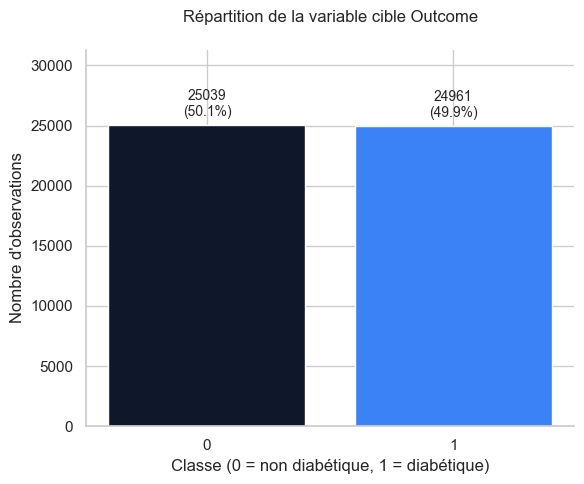

In [19]:
counts = data["Outcome"].value_counts().sort_index()
percentages = (counts / len(data) * 100).round(1)

# Figure un peu plus haute
fig, ax = plt.subplots(figsize=(6, 5))

bars = ax.bar(
    counts.index.astype(str),
    counts.values,
    color=["#0f172a", "#3b82f6"],
    edgecolor="white",
)

# On laisse 20 % de marge au-dessus des barres
ax.set_ylim(0, counts.max() * 1.25)

for i, v in enumerate(counts.values):
    ax.text(
        i,
        v + counts.max() * 0.02,     # petit offset au-dessus de chaque barre
        f"{v}\n({percentages[i]}%)",
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_title("Répartition de la variable cible Outcome", pad=20)  # pad pour éloigner le titre
ax.set_xlabel("Classe (0 = non diabétique, 1 = diabétique)")
ax.set_ylabel("Nombre d'observations")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


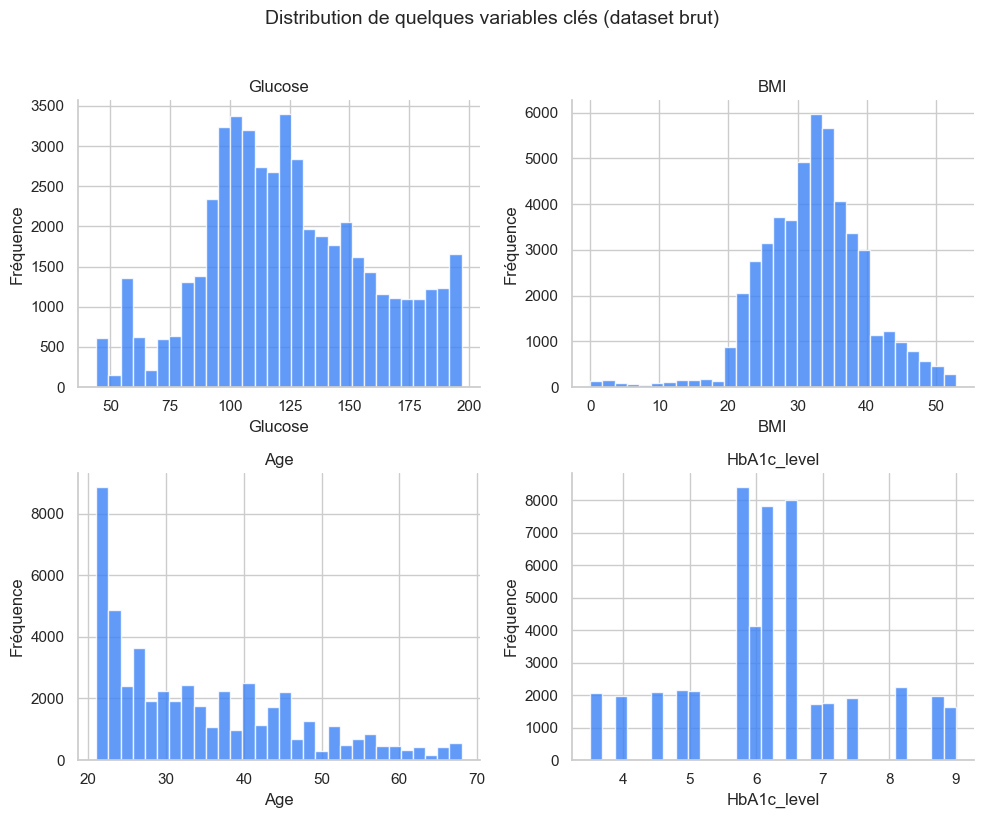

In [20]:
vars_to_plot = ["Glucose", "BMI", "Age", "HbA1c_level"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, col in zip(axes, vars_to_plot):
    ax.hist(data[col].dropna(), bins=30, color="#3b82f6", alpha=0.8, edgecolor="white")
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Fréquence")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.suptitle("Distribution de quelques variables clés (dataset brut)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


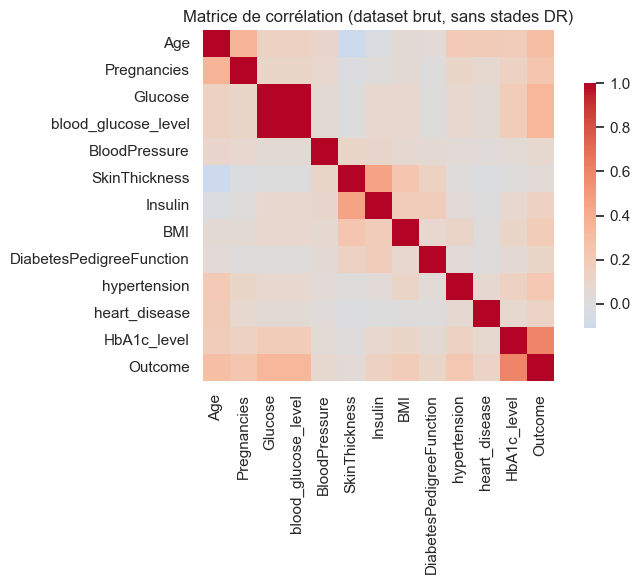

In [21]:
# Colonnes numériques
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Colonnes à exclure de la heatmap (liées à la rétine)
retina_stage_cols = ["left_DR_stage", "right_DR_stage"]

# On enlève celles qui existent vraiment dans le dataset
numeric_cols = [col for col in numeric_cols if col not in retina_stage_cols]

# Matrice de corrélation sans les colonnes rétine
corr = data[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
)
plt.title("Matrice de corrélation (dataset brut, sans stades DR)")
plt.tight_layout()
plt.show()


In [22]:
print("Shape du dataset brut :", data.shape)

display(data.head())

print("\nTypes des colonnes :")
display(data.dtypes.to_frame("dtype"))


Shape du dataset brut : (50000, 19)


,gender,Age,Pregnancies,Glucose,blood_glucose_level,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,hypertension,heart_disease,smoking_history,HbA1c_level,Outcome,left_image_path,right_image_path,left_DR_stage,right_DR_stage
0,Female,39,4,146,146.0,84,40,133,34.4,0.265,0,0,never,8.2,1,data\diabetic_retinopathy\train\535682537302.jpg,data\diabetic_retinopathy\train\870f433e8f37.jpg,0.0,0.0
1,Female,36,12,93,93.0,64,47,111,38.6,0.184,0,0,former,6.6,0,NaN,NaN,NaN,NaN
2,Female,57,7,119,119.0,66,0,0,35.9,0.537,0,0,never,6.0,0,NaN,NaN,NaN,NaN
3,Male,25,0,100,100.0,74,52,0,25.4,0.354,0,0,No Info,3.5,0,NaN,NaN,NaN,NaN
4,Male,26,0,122,122.0,70,0,8,33.8,0.202,0,0,never,8.8,1,data\diabetic_retinopathy\train\454a944eb557.jpg,data\diabetic_retinopathy\train\b1c6f0997e27.jpg,0.0,0.0



Types des colonnes :


,dtype
gender,object
Age,int64
Pregnancies,int64
Glucose,int64
blood_glucose_level,float64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64


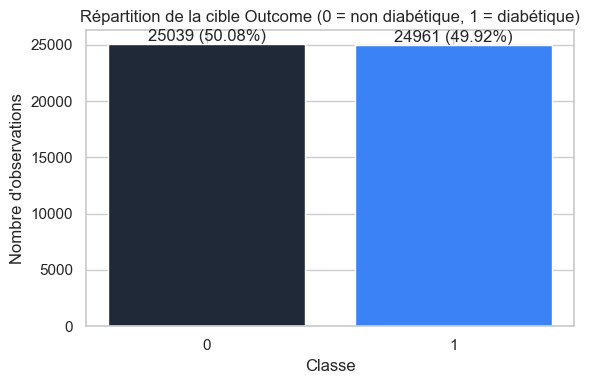

In [23]:
counts = data["Outcome"].value_counts().sort_index()
percentages = (counts / len(data) * 100).round(2)

fig, ax = plt.subplots()
bars = ax.bar(counts.index.astype(str), counts.values, color=["#1f2937", "#3b82f6"])

for i, v in enumerate(counts.values):
    ax.text(i, v + 5, f"{v} ({percentages[i]}%)", ha="center", va="bottom")

ax.set_title("Répartition de la cible Outcome (0 = non diabétique, 1 = diabétique)")
ax.set_xlabel("Classe")
ax.set_ylabel("Nombre d'observations")
plt.tight_layout()
plt.show()


In [24]:
# Colonnes numériques principales
cols_check = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "HbA1c_level",
]

print("Nombre de zéros par colonne (valeurs suspectes) :")
data[cols_check].isin([0]).sum()


Nombre de zéros par colonne (valeurs suspectes) :


Glucose              0
BloodPressure     1878
SkinThickness    15349
Insulin          23567
BMI                 29
HbA1c_level          0
dtype: int64

In [25]:
## 4. Prétraitement des données pour le Modèle 1

# 1) Colonnes à exclure du Modèle 1
retina_cols = ["left_image_path", "right_image_path", "left_DR_stage", "right_DR_stage"]
duplicate_cols = ["blood_glucose_level"]  # info déjà contenue dans Glucose

cols_to_drop = retina_cols + duplicate_cols

data_clean = data.drop(columns=cols_to_drop).copy()

print("Colonnes après suppression des colonnes inutiles :")
print(list(data_clean.columns))

# 2) Conversion de la glycémie : mg/dL -> g/L et renommage
#    (1 g/L = 100 mg/dL, donc on divise par 100)
data_clean["Glucose"] = data_clean["Glucose"] / 100.0
data_clean.rename(columns={"Glucose": "Glycemia_gL"}, inplace=True)

print("\nColonne de glycémie renommée et convertie :")
print(data_clean[["Glycemia_gL"]].head())

# 3) Colonnes où 0 = valeur manquante (non réaliste)
cols_with_zero_as_missing = ["Glycemia_gL", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Remplacer les 0 par NaN
data_clean[cols_with_zero_as_missing] = (
    data_clean[cols_with_zero_as_missing].replace(0, np.nan)
)

print("\nNombre de valeurs manquantes après remplacement des zéros :")
print(data_clean[cols_with_zero_as_missing].isna().sum())

# 4) Imputation : remplacer les NaN par la médiane de chaque colonne
for col in cols_with_zero_as_missing:
    median_value = data_clean[col].median()
    data_clean[col].fillna(median_value, inplace=True)

print("\nValeurs manquantes après imputation (devrait être 0 partout) :")
print(data_clean.isna().sum())


Colonnes après suppression des colonnes inutiles :
['gender', 'Age', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'Outcome']

Colonne de glycémie renommée et convertie :
   Glycemia_gL
0         1.46
1         0.93
2         1.19
3         1.00
4         1.22

Nombre de valeurs manquantes après remplacement des zéros :
Glycemia_gL          0
BloodPressure     1878
SkinThickness    15349
Insulin          23567
BMI                 29
dtype: int64

Valeurs manquantes après imputation (devrait être 0 partout) :
gender                      0
Age                         0
Pregnancies                 0
Glycemia_gL                 0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
hypertension                0
heart_disease               0
smoking_history             0

C:\Users\klever\AppData\Local\Temp\ipykernel_15068\3178705096.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean[col].fillna(median_value, inplace=True)
C:\Users\klever\AppData\Local\Temp\ipykernel_15068\3178705096.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [26]:
## 5. Nettoyage de la variable de tabagisme

print("Modalités initiales de smoking_history :")
print(data_clean["smoking_history"].value_counts())

def map_smoking_status(x: str) -> str:
    if x == "never":
        return "never"
    elif x in ["current", "former", "ever", "not current"]:
        return "smoker"
    else:
        # "No Info" ou valeur inconnue
        return "unknown"

data_clean["smoking_status"] = data_clean["smoking_history"].apply(map_smoking_status)

print("\nNouvelle répartition de smoking_status :")
print(data_clean["smoking_status"].value_counts())

# Suppression de l'ancienne colonne
data_clean = data_clean.drop(columns=["smoking_history"])

data_clean.head()


Modalités initiales de smoking_history :
smoking_history
never          20291
No Info        11255
current         7471
former          4362
not current     3905
ever            2716
Name: count, dtype: int64

Nouvelle répartition de smoking_status :
smoking_status
never      20291
smoker     18454
unknown    11255
Name: count, dtype: int64


,gender,Age,Pregnancies,Glycemia_gL,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,hypertension,heart_disease,HbA1c_level,Outcome,smoking_status
0,Female,39,4,1.46,84.0,40.0,133.0,34.4,0.265,0,0,8.2,1,never
1,Female,36,12,0.93,64.0,47.0,111.0,38.6,0.184,0,0,6.6,0,smoker
2,Female,57,7,1.19,66.0,30.0,136.0,35.9,0.537,0,0,6.0,0,never
3,Male,25,0,1.00,74.0,52.0,136.0,25.4,0.354,0,0,3.5,0,unknown
4,Male,26,0,1.22,70.0,30.0,8.0,33.8,0.202,0,0,8.8,1,never


In [27]:
## 6. Encodage des variables catégorielles et split

target_column = "Outcome"

# Colonnes catégorielles à encoder (les autres sont numériques)
categorical_cols = ["gender", "smoking_status"]

# Encodage one-hot
data_model = pd.get_dummies(
    data_clean,
    columns=categorical_cols,
    drop_first=True  # évite les variables parfaitement colinéaires
)

print("Colonnes finales après encodage :")
print(list(data_model.columns))

# Séparation X / y
X = data_model.drop(columns=[target_column])
y = data_model[target_column]

# Split train / test (80 / 20) avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nShapes des ensembles :")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)


Colonnes finales après encodage :
['Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level', 'Outcome', 'gender_Male', 'gender_Other', 'smoking_status_smoker', 'smoking_status_unknown']

Shapes des ensembles :
X_train : (40000, 15)
X_test  : (10000, 15)
y_train : (40000,)
y_test  : (10000,)


In [28]:
## 7. Fonction utilitaire pour évaluer les modèles

def evaluate_classifier(name, y_test, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"✅ Résultats pour {name}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC AUC   : {auc:.4f}")
    print("\nClassification report :")
    print(classification_report(y_test, y_pred))

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
    }

def plot_confusion_matrix(y_test, y_pred, title="Matrice de confusion"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Prédit 0", "Prédit 1"],
        yticklabels=["Réel 0", "Réel 1"],
    )
    plt.title(title)
    plt.ylabel("Valeur réelle")
    plt.xlabel("Valeur prédite")
    plt.tight_layout()
    plt.show()

results = []


✅ Résultats pour LogisticRegression
Accuracy  : 0.8302
Precision : 0.8349
Recall    : 0.8225
F1-score  : 0.8287
ROC AUC   : 0.9192

Classification report :
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5008
           1       0.83      0.82      0.83      4992

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



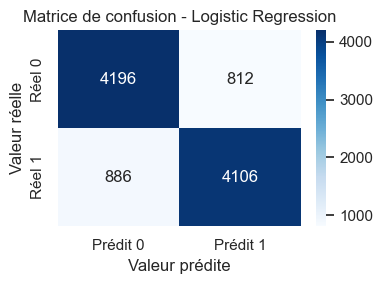

In [29]:
## 8. Modèle linéaire : Régression Logistique (baseline)

logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])

logreg_pipeline.fit(X_train, y_train)

y_pred_log = logreg_pipeline.predict(X_test)
y_proba_log = logreg_pipeline.predict_proba(X_test)[:, 1]

results.append(
    evaluate_classifier("LogisticRegression", y_test, y_pred_log, y_proba_log)
)

plot_confusion_matrix(y_test, y_pred_log, title="Matrice de confusion - Logistic Regression")


✅ Résultats pour RandomForest
Accuracy  : 0.8606
Precision : 0.8575
Recall    : 0.8644
F1-score  : 0.8609
ROC AUC   : 0.9452

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5008
           1       0.86      0.86      0.86      4992

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



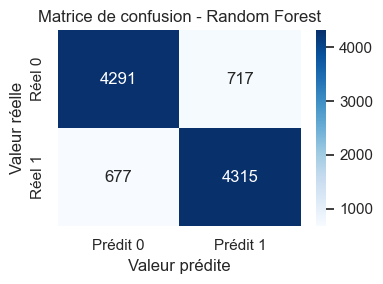

In [30]:
## 9. Modèle 2 : Random Forest

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

results.append(
    evaluate_classifier("RandomForest", y_test, y_pred_rf, y_proba_rf)
)

plot_confusion_matrix(y_test, y_pred_rf, title="Matrice de confusion - Random Forest")


In [35]:
import pandas as pd

# Importance des features
feature_importances = pd.Series(
    rf_clf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Afficher les 10 plus importantes
top_k = 10
top_features = feature_importances.head(top_k)
top_features


HbA1c_level                 0.380099
Glycemia_gL                 0.140211
BMI                         0.094294
Age                         0.087491
DiabetesPedigreeFunction    0.063163
BloodPressure               0.049278
Pregnancies                 0.048962
Insulin                     0.047686
SkinThickness               0.041375
hypertension                0.022738
dtype: float64

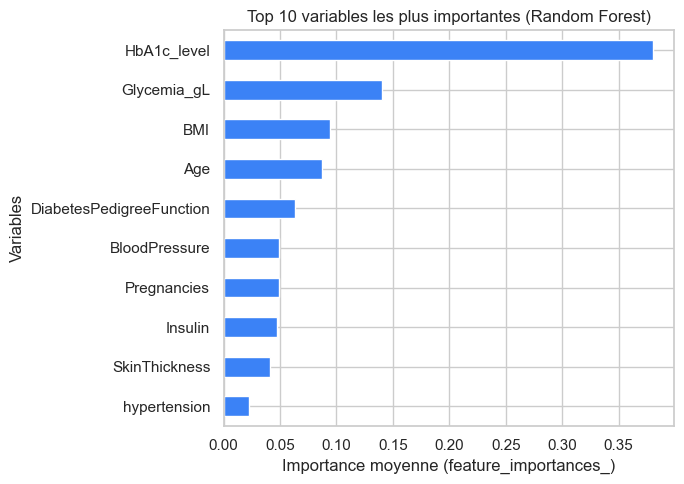

In [36]:
plt.figure(figsize=(7, 5))
top_features.sort_values().plot(kind="barh", color="#3b82f6")
plt.title(f"Top {top_k} variables les plus importantes (Random Forest)")
plt.xlabel("Importance moyenne (feature_importances_)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


✅ Résultats pour HistGradientBoosting
Accuracy  : 0.8623
Precision : 0.8614
Recall    : 0.8630
F1-score  : 0.8622
ROC AUC   : 0.9477

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5008
           1       0.86      0.86      0.86      4992

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



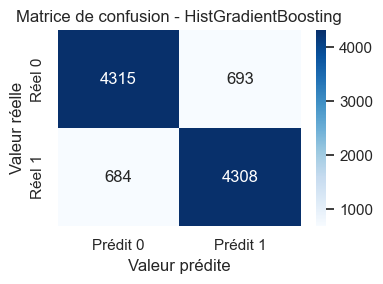

In [31]:
## 10. Modèle 3 : HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=RANDOM_STATE,
)

hgb_clf.fit(X_train, y_train)

y_pred_hgb = hgb_clf.predict(X_test)
y_proba_hgb = hgb_clf.predict_proba(X_test)[:, 1]

results.append(
    evaluate_classifier("HistGradientBoosting", y_test, y_pred_hgb, y_proba_hgb)
)

plot_confusion_matrix(y_test, y_pred_hgb, title="Matrice de confusion - HistGradientBoosting")


In [32]:
## 11. Comparaison globale des modèles

results_df = pd.DataFrame(results)
results_df = results_df.set_index("model").sort_values("roc_auc", ascending=False)
results_df


,accuracy,precision,recall,f1,roc_auc
model,,,,,
HistGradientBoosting,0.8623,0.861428,0.862981,0.862204,0.947717
RandomForest,0.8606,0.857512,0.864383,0.860934,0.945202
LogisticRegression,0.8302,0.834892,0.822516,0.828658,0.919151


In [33]:
## 12. Pipeline RandomForest complet (prétraitement + modèle) pour la mise en production

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

target_column = "Outcome"
categorical_cols = ["gender", "smoking_status"]

# Toutes les colonnes numériques = toutes les autres (sauf cible et cat.)
numeric_cols = [
    col for col in data_clean.columns
    if col not in categorical_cols + [target_column]
]

print("Colonnes numériques :", numeric_cols)
print("Colonnes catégorielles :", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

rf_prod = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_prod),
])

# On utilise le même X_train / X_test mais cette fois à partir de data_clean
X_full = data_clean.drop(columns=[target_column])
y_full = data_clean[target_column]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_full,
)

rf_pipeline.fit(X_train_p, y_train_p)

y_pred_pipe = rf_pipeline.predict(X_test_p)
y_proba_pipe = rf_pipeline.predict_proba(X_test_p)[:, 1]

print("\n📊 Performance du pipeline RandomForest (avec prétraitement intégré) :")
_ = evaluate_classifier("RandomForest_pipeline", y_test_p, y_pred_pipe, y_proba_pipe)

# 💾 Sauvegarde du modèle pour l'API FastAPI
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "diabetes_rf_pipeline.joblib"
joblib.dump(rf_pipeline, model_path)

print(f"\n💾 Modèle sauvegardé dans : {model_path}")


Colonnes numériques : ['Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level']
Colonnes catégorielles : ['gender', 'smoking_status']

📊 Performance du pipeline RandomForest (avec prétraitement intégré) :
✅ Résultats pour RandomForest_pipeline
Accuracy  : 0.8597
Precision : 0.8550
Recall    : 0.8658
F1-score  : 0.8604
ROC AUC   : 0.9447

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5008
           1       0.85      0.87      0.86      4992

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


💾 Modèle sauvegardé dans : ..\models\diabetes_rf_pipeline.joblib


In [34]:
## 13. Exemple : prédiction pour un patient fictif

example = {
    "Pregnancies": 2,
    "Glycemia_gL": 1.4,
    "BloodPressure": 80,
    "SkinThickness": 25,
    "Insulin": 100,
    "BMI": 28.5,
    "DiabetesPedigreeFunction": 0.45,
    "Age": 35,
    "heart_disease": 0,
    "hypertension": 0,
    "HbA1c_level": 6.8,
    "gender": "Female",
    "smoking_status": "never",
}

example_df = pd.DataFrame([example])

proba_example = rf_pipeline.predict_proba(example_df)[:, 1][0]
pred_example = rf_pipeline.predict(example_df)[0]

print("Probabilité de diabète :", proba_example)
print("Classe prédite (0 = non diabétique, 1 = diabétique) :", pred_example)


Probabilité de diabète : 0.9866666666666667
Classe prédite (0 = non diabétique, 1 = diabétique) : 1
